# Scikits DAE solver

In this notebook, we show some examples of solving a DAE model using the Scikits DAE solver, which interfaces with the [SUNDIALS](https://computation.llnl.gov/projects/sundials) library via the [scikits-odes](https://scikits-odes.readthedocs.io/en/latest/) Python interface

In [1]:
# Setup
import pybamm
import tests
import numpy as np
import os
import matplotlib.pyplot as plt
from pprint import pprint
os.chdir(pybamm.__path__[0]+'/..')

# Create solver
dae_solver = pybamm.ScikitsDaeSolver()

## Integrating DAEs

In the simplest case, the `integrate` method of the DAE solver needs to be passed a function that returns residuals given `(t,y,ydot)`, initial conditions `y0`, and a time `t_eval` at which to return the solution:

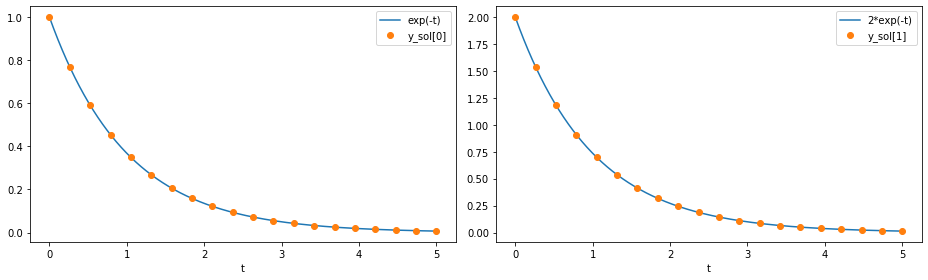

In [2]:
def exponential_decay_dae(t, y, ydot):
    return [-y[0] - ydot[0], 2 * y[0] - y[1]]

# Solve
y0 = np.array([1, 2])
t_eval = np.linspace(0, 5, 20)
solution = dae_solver._integrate(exponential_decay_dae, y0, t_eval)

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

def plot(t_sol, y_sol):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
    ax1.plot(t_fine, np.exp(-t_fine), t_sol, y_sol[0], "o")
    ax1.set_xlabel("t")
    ax1.legend(["exp(-t)", "y_sol[0]"], loc="best")

    ax2.plot(t_fine, 2*np.exp(-t_fine), t_sol, y_sol[1], "o")
    ax2.set_xlabel("t")
    ax2.legend(["2*exp(-t)", "y_sol[1]"], loc="best")

    plt.tight_layout()
    plt.show()
    
plot(solution.t, solution.y)

We can also provide the mass matrix and Jacobian (both must be provided together)

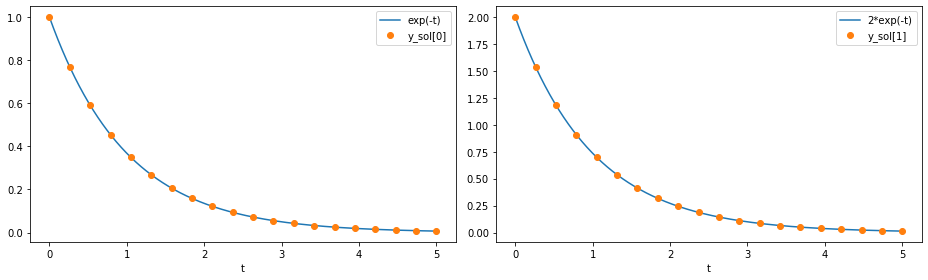

In [3]:
def jacobian(t, y):
    return np.array([[-1.0, 0.0], [2, -1]])

mass_matrix = np.array([[1, 0], [0, 0]])

solution = dae_solver._integrate(exponential_decay_dae, y0, t_eval, jacobian=jacobian, mass_matrix=mass_matrix)
plot(solution.t, solution.y)

Finally, we can specify events at which the solver should terminate

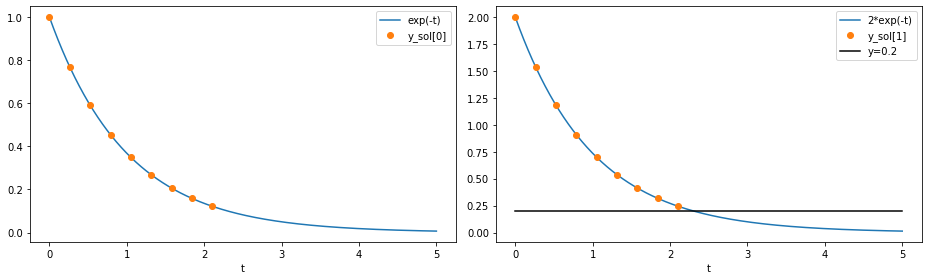

In [4]:
def y1_equal_0pt2(t, y):
    return y[1] - 0.2

# Solve
solution = dae_solver._integrate(exponential_decay_dae, y0, t_eval, events=[y1_equal_0pt2])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, np.exp(-t_fine), solution.t, solution.y[0], "o")
ax1.set_xlabel("t")
ax1.legend(["exp(-t)", "y_sol[0]"], loc="best")

ax2.plot(t_fine, 2*np.exp(-t_fine), solution.t, solution.y[1], "o", t_fine, 0.2 * np.ones_like(t_fine), "k")
ax2.set_xlabel("t")
ax2.legend(["2*exp(-t)", "y_sol[1]", "y=0.2"], loc="best")

plt.tight_layout()
plt.show()

## Finding consistent initial conditions

The solver will fail if initial conditions that are inconsistent with the algebraic equations are provided.

In [5]:
y0_bad = np.array([1, 3])
print("algebraic residual at (0, y0_bad, [0]) is {}".format(exponential_decay_dae(0, y0_bad, [0])[1]))
try:
    solution = dae_solver._integrate(exponential_decay_dae, y0_bad, t_eval)
except pybamm.SolverError as e:
    print(e)

algebraic residual at (0, y0_bad, [0]) is -1
Error test failures occurred too many times during one internal time step or minimum step size was reached.


However, we can use `calculate_consistent_initial_conditions` to obtain consistent initial conditions, starting from a guess of bad initial conditions, using a simple root-finding algorithm.

y0_fixed = [1. 2.]

algebraic residual at (0, y0_fixed, [0]) is 0.0


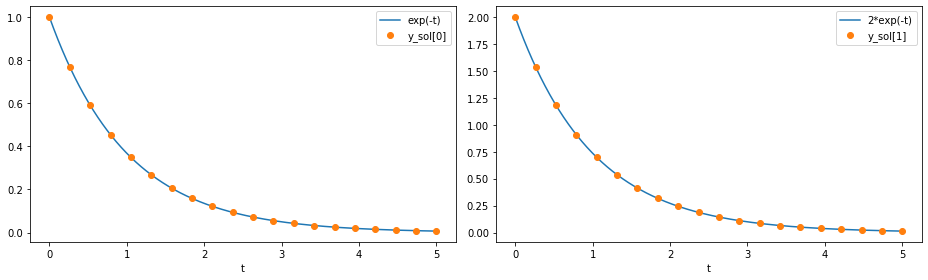

In [6]:
def exponential_decay_dae_rhs(t, y):
    return np.array([exponential_decay_dae(t, y, [0])[0]])

def exponential_decay_dae_algebraic(t, y):
    return np.array([exponential_decay_dae(t, y, [0])[1]])

y0_fixed = dae_solver.calculate_consistent_initial_conditions(
    exponential_decay_dae_rhs, exponential_decay_dae_algebraic, y0_bad
)
print("y0_fixed = {}\n".format(y0_fixed))
print("algebraic residual at (0, y0_fixed, [0]) is {}".format(exponential_decay_dae(0, y0_fixed, [0])[1]))

solution = dae_solver._integrate(exponential_decay_dae, y0_fixed, t_eval)
plot(solution.t, solution.y)

## Solving a model

The `solve` method is common to all DAE solvers. It takes a model, which contains all of the above information (residuals function, initial conditions and optionally jacobian, mass matrix, events), and a time to evaluate `t_eval`, and calls `integrate` to solve this model. 

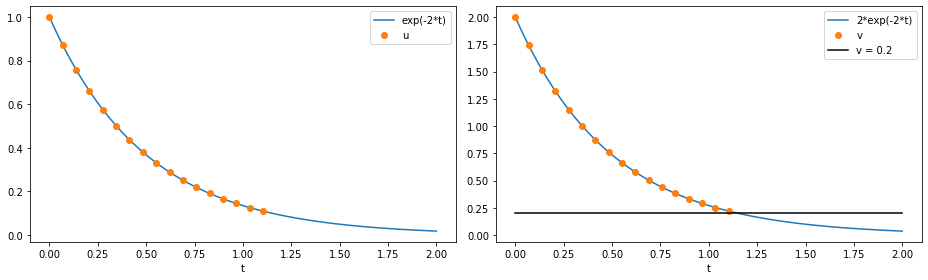

In [7]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
v = pybamm.Variable("v")
model.rhs = {u: -v} # du/dt = -v
model.algebraic = {v: 2 * u - v} # 2*v = u
model.initial_conditions = {u: 1, v: 1} # bad initial conditions, solver fixes
model.events['v=0.2'] = v - 0.2
model.variables = {"u": u, "v": v}

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model)

# Solve #################################
t_eval = np.linspace(0, 2, 30)
solution = dae_solver.solve(model, t_eval)
#########################################

# Extract u and v
t_sol = solution.t
u = solution["u"]
v = solution["v"]

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, np.exp(-2 * t_fine), t_sol, u(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["exp(-2*t)", "u"], loc="best")

ax2.plot(t_fine, 2 * np.exp(-2 * t_fine), t_sol, v(t_sol), "o", t_fine, 0.2 * np.ones_like(t_fine), "k")
ax2.set_xlabel("t")
ax2.legend(["2*exp(-2*t)", "v", "v = 0.2"], loc="best")

plt.tight_layout()
plt.show()

Note that the discretisation or solver will have created the mass matrix and jacobian algorithmically, using the expression tree, so we do not need to calculate and input these manually.